This notebook explains how to get a first grid2op environment, then use the data it needs to generate some loads and renewables (and a shitty market design) and load this second environment.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("This notebook uses the last version of grid2op. You can install it with:\n"\
      "\t{} -m pip install grid2op".format(sys.executable))
import grid2op
if grid2op.__version__ < "0.6.0":
    raise RuntimeError("Impossible to run this notebook without grid2op version 0.6.0 installed.")
from grid2op.Chronics import ChangeNothing
from grid2op.Plot import PlotMatplotlib

#path_grid = os.path.join("data", "case118_l2rpn")

This notebook uses the last version of grid2op. You can install it with:
	/usr/bin/python3 -m pip install grid2op


In [2]:
# Chronix2grid modules
sys.path.insert(0, '..')
import generation.generate_chronics as gen
import generation.consumption.generate_load as gen_loads
import generation.renewable.generate_solar_wind as gen_enr
import generation.thermal.generate_dispatch as gen_dispatch

import generation.dispatch.EconomicDispatch as ec
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch
import kpi.main as kpis

In [3]:
isRunCase118=False
isRunCase14=True

computeHazardsMaintenance=False

In [4]:
### CONSTANT

## Generation step of chronix2grid
if isRunCase118:
    INPUT_FOLDER = 'generation/input'
    CASE = 'case118_l2rpn'
    OUTPUT_FOLDER = os.path.join('generation/output', CASE)
    path_grid = os.path.join(INPUT_FOLDER, CASE)
    grid_path = os.path.join(path_grid, "L2RPN_2020_case118_redesigned.json")

    start_date = "2012-01-01"
    weeks = 1
    n_scenarios = 1
        # Detailed configuration to set in <INPUT_FOLDER>/<CASE>/params.json

    #Intermediate folder used by dispatch
    dispatch_case_folder = os.path.join(INPUT_FOLDER, CASE, 'dispatch')
    
    ## KPI computation phase
    KPI_INPUT_FOLDER = 'kpi/input'
    IMAGES_FOLDER = 'kpi/images'
        # Detailed configuration to set in <KPI_INPUT_FOLDER>/params.json

In [5]:
if isRunCase14:

    ### CONSTANT

    ## Generation step of chronix2grid
    INPUT_FOLDER = 'generation/input'
    OUTPUT_FOLDER = 'generation/output/case14'
    CASE = 'case14_realistic'
    path_grid = os.path.join(INPUT_FOLDER, CASE)
    grid_path = os.path.join(path_grid, "case14_realistic.json")

    start_date = "2012-01-01"
    weeks = 4
    n_scenarios = 16
        # Detailed configuration to set in <INPUT_FOLDER>/<CASE>/params.json
        
    #Intermediate folder used by dispatch
    dispatch_case_folder = os.path.join(INPUT_FOLDER, 'dispatch/case14/')


    ## KPI computation phase
    KPI_INPUT_FOLDER = 'kpi/input'
    IMAGES_FOLDER = 'kpi/images'
        # Detailed configuration to set in <KPI_INPUT_FOLDER>/params.json

# Dispatch Parameters 

In [6]:
#20min time computation for a year with every generators at monthly resolution --- Fail on month of june
#8min time computation for a year with every generators at weekly resolution --- Fail for last 2 weeks of june
#10.5min time computation for a year with every generators at daily resolution --- Fail for 17 and 24 of june 
#=>no thermal on those days, probably due to ramps! But was converging when looking only per carrier type

#1min time computation for a year with every carrier at monthly resolution --- Fail on month of june
#6min time computation for a year with every carrier at daily resolution --- Fail on month of june
params_opf = {
    'step_opf_min': 5,
    'mode_opf': 'month',
    'reactive_comp': 1.025,
}

losses_pct = 3.0
DispatchByCarrierOnly=False


# Load the environment

In [7]:
path_grid = os.path.join(INPUT_FOLDER, CASE)

env118_withoutchron = grid2op.make("blank",  # to generate a blank environment
                      grid_path=grid_path, # assign it the 118 grid
                      chronics_class=ChangeNothing, # tell it to change nothing (not the most usable environment...)
                  )

# Check the Energy Mix apriori

In [8]:
%run kpi/Generator_parameter_checker.py
Target_EM_percentage=pd.DataFrame(data=[4,6,35,15,40],columns=['target_energy_mix'],
                                  index=['solar','wind','nuclear','hydro','thermal'])

if isRunCase14:
    PeakLoad=308
    AverageLoad=257
elif isRunCase118:
    PeakLoad=4200
    AverageLoad=2800
    
CapacityFactor=pd.DataFrame(data=[15,25,95,30,np.nan],columns=['capacity_factor'],
                            index=['solar','wind','nuclear','hydro','thermal'])
Capacity_df=EnergyMix_AprioriChecker(env118_withoutchron,Target_EM_percentage, PeakLoad, AverageLoad, CapacityFactor )
Capacity_df

,target_energy_mix,pmax,capacity_mix,capacity_factor,Apriori_energy_mix,revised_pmax
solar,4,110.0,20.4,15.0,6.420233,68.533333
wind,6,70.0,13.0,25.0,6.809339,61.680000
nuclear,35,140.0,25.9,95.0,51.750973,94.684211
hydro,15,100.0,18.5,30.0,11.673152,128.500000
thermal,40,120.0,22.2,NaN,23.346304,213.315789


# II Generate the data

**You can set generation configuration such as number of scenarios, start date, number of weeks, noise intensities, timestep... in INPUT_FOLDER/CASE/params.json**

# II A) Generate loads and renewables

Chronix2grid generation process which implements Balthazar method. CSV writting takes long

In [9]:
## Reading parameters
year, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE, start_date, weeks)
print(year)

## Whole generation
# gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)


## OR ============

# Separate generation for load and renewables


# Create folders
dispatch_input_folder = os.path.join(dispatch_case_folder, str(year))
dispatch_output_folder = os.path.join(OUTPUT_FOLDER, str(year))

# Make sure the output folders exist
main_folder = os.path.join(dispatch_input_folder)
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

out_folder = os.path.join(dispatch_output_folder)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Make sure the seeds are the same, whether computation is parallel or sequential
seeds = [np.random.randint(low=0, high=2**31) for _ in range(n_scenarios)]


# Launch load generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    load, load_forecasted = gen_loads.main(i, dispatch_input_folder, seed, params, loads_charac, 
                                           load_weekly_pattern, write_results = True)

    print('\n')

Importing parameters ...
Importing loads and prods parameters ...
2012
================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files in zipped csv in "generation/input/dispatch/case14/2012/Scenario_0"


================ Generating scenario number 1 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files in zipped csv in "generation/input/dispatch/case14/2012/Scenario_1"


================ Generating scenario number 2 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files in zipped csv in "generation/input/dispatch/case14/2012/Scenario_2"


================ Generating scenario number 3 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files

In [10]:
!ls $OUTPUT_FOLDER

2012


## Check load hypothesis (peak and average)

**if this differs by too much, you should update the computation of the Energy Mix a priori and revise some calibration if not satisfactory**

In [11]:
CurrentPeakLoad=load.sum(axis=1).max()
print('the expected peak load was: '+str(PeakLoad))
print('the actual peak load is: '+str(CurrentPeakLoad))

the expected peak load was: 308
the actual peak load is: 310.7007994542859


In [12]:
CurrentAverageLoad=load.sum(axis=1).mean()
print('the expected average load was: '+str(AverageLoad))
print('the actual average load is: '+str(CurrentAverageLoad))

the expected average load was: 257
the actual average load is: 256.4673110281499


## Generate Renewables

In [13]:
# Launch solar and wind generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    prod_solar, prod_solar_forecasted, prod_wind, prod_wind_forecasted = gen_enr.main(i, dispatch_input_folder, seed,params, prods_charac, solar_pattern, 
                                                                                      write_results = True)
    # Function that will be used when dispatch is ready
    # For now it only generates hazards and maintenance
    gen_dispatch.main(i, load, prod_solar, prod_wind, out_folder, seed, params,prods_charac, lines, compute_hazards=computeHazardsMaintenance)
    print('\n')

================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Generating maintenance and hazard signals ...


================ Generating scenario number 1 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Generating maintenance and hazard signals ...


================ Generating scenario number 2 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Generating maintenance and hazard signals ...


================ Generating scenario number 3 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Generating m

In [14]:
!ls generation/output/case14/2012/

Scenario_0   Scenario_11  Scenario_14  Scenario_3  Scenario_6  Scenario_9
Scenario_1   Scenario_12  Scenario_15  Scenario_4  Scenario_7
Scenario_10  Scenario_13  Scenario_2   Scenario_5  Scenario_8


In [15]:
## Reading parameters
#year, n_scenarios, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE)
#print(year)
#gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)

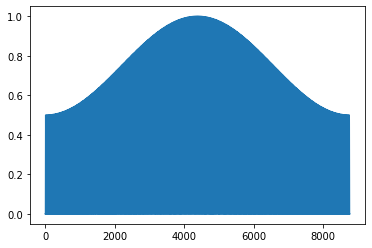

In [16]:
plt.plot(solar_pattern)

## Check Ramps and Pmin/Pmax Generator parameters A priori

### Select the scenario you want to check first

In [17]:
%run kpi/Generator_parameter_checker.py

losses_pct = 3.0  # losses as pct of load
[isThermalInTrouble,isNuclearInTrouble,IsRampUpInTrouble,IsRampDownInTrouble]=Ramps_Pmax_Pmin_APrioriCheckers(
    env118_withoutchron,Capacity_df,dispatch_input_folder,losses_pct,PeakLoad)


 the wind share is 8.4
the wind share was expected to be 6
the solar share is 3.0
the solar share was expected to be 4

 the max load is 331.45400000000006
the expected peak load was 308

 the max net load is 316.62399999999997

 the min net load is 137.28500000000003
the nuclear capacity is 140.0
the max net load decrease 10.341000000000008
the nuclear max ramp Down is 5.0
are we in trouble for nuclear:True

 the max net load ramp up is 10.341000000000008
the max generation ramp up is 30.0

 the max net load ramp down is -10.861999999999995
the max nuclear + hydro ramp down is 20.0


/home/donnotben/Documents/chronix2grid/chronix2grid/kpi/Generator_parameter_checker.py:219: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [18]:
print("Are the thermal reactors \"in trouble\": {}".format(isThermalInTrouble))
print("Are the nuclear reactors \"in trouble\": {}".format(isNuclearInTrouble))
print("Are the ramp up \"in trouble\": {}".format(IsRampUpInTrouble))
print("Are the ramp down \"in trouble\": {}".format(IsRampDownInTrouble))

Are the thermal reactors "in trouble": True
Are the nuclear reactors "in trouble": True
Are the ramp up "in trouble": False
Are the ramp down "in trouble": False


In [19]:
%run kpi/Generator_parameter_checker.py
Aposteriori_renewableCapacityFactor_Checkers(env118_withoutchron,Capacity_df, dispatch_input_folder)


 the max wind production 70.3

 the expected max wind production was 70.0

 the max solar production 49.099999999999994

 the expected max solar production was 110.0

 the solar capacity factor is: 0.07307810368349246

 the expected solar capacity factor was: 15.0

 the wind capacity factor is: 0.31545856513881754

 the expected wind capacity factor was: 25.0


[0.07307810368349246, 0.31545856513881754]

### Compute some KPIs for solar, wind and load

#### Good comparison can be obtained by setting "renewable_ninja" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
Images are saved in IMAGES_FOLDER 

In [20]:
# wind_solar_only = True
# if not os.path.exists(KPI_INPUT_FOLDER):
#     os.mkdir(KPI_INPUT_FOLDER)
# kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, IMAGES_FOLDER, year, CASE, n_scenarios, wind_solar_only, params)

## Create The EconomicDispatch instance : a high level wrapper around a Pypsa net

To install PyPSA correctly <br>
`pip3 install -U git+http://github.com/PyPSA/PyPSA.git@8d527e25fa9876cac66957448f449a1c901901d2`

You also need to install the solver that pypsa is calling. For instance cbc solver. On Fedora do `dnf install coin-or-Cbc.x86_64`

In [21]:
%load_ext autoreload
%autoreload 2
import generation.dispatch.EconomicDispatch as ec
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch

In [22]:
dispatch = ec.Dispatch.from_gri2op_env(env118_withoutchron)
dispatch.modify_marginal_costs({'hydro': 3, 'nuclear': 8})
dispatch.read_hydro_guide_curves(os.path.join(INPUT_FOLDER, 'patterns', 'hydro_french.csv'))

In [23]:
dispatch.plot_ramps()

## II B) Run a unit commitment model

we will use pypsa. To avoid messing with the names, and make sure to have data in the proper shape, it is better, I think, to create the pypsa network directly from the grid2op environment.

For more information on unit commitment see https://pypsa.org/examples/unit-commitment.html for example.

### Run opf

In [24]:
# The run is by scenario
for subpath in os.listdir(dispatch_input_folder):
    
    if subpath in ['.DS_Store']:
        continue
    
    this_path = os.path.join(dispatch_input_folder, subpath)
    dispatch.read_load_and_res_scenario(os.path.join(this_path, 'load_p.csv.bz2'),
                                        os.path.join(this_path, 'prod_p.csv.bz2'),
                                        scenario_name=subpath)
    dispatch.make_hydro_constraints_from_res_load_scenario()
    agg_load_without_renew = dispatch.net_load(losses_pct, name=dispatch.loads.index[0])
    
    # Example of how to extract info on the largest ramps
    print(f'5 largest ramps reached by the agg_load_without_renew:')
    print(dispatch.nlargest_ramps(5, losses_pct))
    
    # Prepare gen constraints for EDispatch module
    hydro_constraints = {'p_max_pu': dispatch._max_hydro_pu.copy(), 'p_min_pu': dispatch._min_hydro_pu.copy()}
    
    # Run Economic Disptach using submodule EDisptach_L2RPN_2020
    # **  **  **  **  **  **  **  **  **  **  **  **  **  **
    chronix_scenario, term_conditions = dispatch.run(
                                        agg_load_without_renew,
                                        params=params_opf,
                                        gen_constraints=hydro_constraints,
                                        ramp_mode=run_economic_dispatch.RampMode.none,
                                        by_carrier=DispatchByCarrierOnly  # True to run the dispatch only aggregated generators by carrier
                                    )
    # save prods chronics
    dispatch.save_results(dispatch_output_folder)
    
    #TODO this should not be done in the notebook, but in chronix2grid ! These files are output of chronix2grid.
    import shutil
    shutil.copy(os.path.join(dispatch_input_folder, subpath, 'load_p_forecasted.csv.bz2'),
                os.path.join(dispatch_output_folder, subpath, 'chronics', 'load_p_forecasted.csv.bz2'))
    shutil.copy(os.path.join(dispatch_input_folder, subpath, 'wind_p_forecasted.csv.bz2'),
                os.path.join(dispatch_output_folder, subpath, 'chronics', 'wind_p_forecasted.csv.bz2'))
    shutil.copy(os.path.join(dispatch_input_folder, subpath, 'solar_p_forecasted.csv.bz2'),
                os.path.join(dispatch_output_folder, subpath, 'chronics', 'solar_p_forecasted.csv.bz2'))
    
# TODO if there are failures, write it somewhere, for now it's only detected in the very verbose output cell.
# for example you can do a report at the end 'looking like failures for scenariis xxx'

5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-17 18:45:00  7.931
2012-01-11 13:00:00  7.187
2012-01-08 18:25:00  7.059
2012-01-07 12:15:00  7.011
2012-01-12 13:55:00  6.781
Preprocessing input data..
Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.87e+07


-- opf succeeded  >Objective value (should be greater than zero!
Total time 0.15 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_12/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-07 22:50:00  9.370
2012-01-28 11:50:00  8.772
2012-01-16 22:45:00  7.707
2012-01-03 10:40:00  7.602
2012-01-22 12:50:00  7.469
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.01e+07


-- opf succeeded  >Objective value (should be greater than zero!
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_6/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-24 18:40:00  9.261
2012-01-04 06:40:00  7.719
2012-01-22 13:10:00  7.366
2012-01-22 13:05:00  7.282
2012-01-22 13:00:00  7.200
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_8/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-12 12:45:00  8.911
2012-01-25 22:30:00  8.237
2012-01-14 13:25:00  7.753
2012-01-04 12:40:00  7.417
2012-01-24 13:15:00  7.042
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.61s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.12 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_4/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-04 13:55:00  8.483
2012-01-12 10:55:00  7.632
2012-01-12 18:55:00  7.613
2012-01-09 11:00:00  7.378
2012-01-15 11:05:00  7.353
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.69s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_15/chronics
5 largest ramps reached by the agg_load_without_renew:
                           
datetime                   
2012-01-13 11:15:00  10.341
2012-01-09 13:35:00   8.793
2012-01-18 10:45:00   8.338
2012-01-08 14:15:00   8.281
2012-01-19 06:35:00   7.604
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.12 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_2/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-27 10:30:00  8.720
2012-01-23 14:00:00  7.402
2012-01-22 11:45:00  7.202
2012-01-22 12:45:00  7.175
2012-01-14 12:05:00  7.163
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.67s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_5/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-25 12:40:00  9.429
2012-01-19 11:35:00  9.123
2012-01-16 13:00:00  8.975
2012-01-04 11:40:00  8.854
2012-01-22 11:05:00  8.669
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_0/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-23 12:50:00  9.026
2012-01-25 18:40:00  8.970
2012-01-18 12:10:00  8.874
2012-01-11 07:15:00  8.352
2012-01-27 13:50:00  8.263
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_3/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-17 18:25:00  8.340
2012-01-19 12:20:00  7.802
2012-01-09 10:10:00  7.568
2012-01-18 10:30:00  7.502
2012-01-25 12:05:00  7.239
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.75s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.04e+07


-- opf succeeded  >Objective value (should be greater than zero!
Total time 0.13 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_11/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-12 12:55:00  8.196
2012-01-16 12:00:00  8.023
2012-01-16 06:45:00  7.416
2012-01-26 11:05:00  7.378
2012-01-26 13:00:00  7.120
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.58s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.61e+07


-- opf succeeded  >Objective value (should be greater than zero!
Total time 0.12 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_7/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-21 09:55:00  8.583
2012-01-19 11:45:00  7.962
2012-01-13 22:50:00  7.613
2012-01-20 19:10:00  7.313
2012-01-23 11:05:00  7.233
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_13/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-02 11:50:00  7.908
2012-01-09 11:45:00  7.512
2012-01-15 10:00:00  7.484
2012-01-04 05:25:00  7.310
2012-01-27 17:50:00  7.307
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.11 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_9/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-23 10:35:00  7.874
2012-01-17 11:55:00  7.823
2012-01-21 10:05:00  7.772
2012-01-18 06:40:00  7.519
2012-01-18 18:40:00  7.207
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.65s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.12 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_1/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-23 11:50:00  8.747
2012-01-07 12:05:00  8.468
2012-01-25 13:45:00  8.151
2012-01-17 22:45:00  7.922
2012-01-16 13:00:00  7.320
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.65s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.12 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_10/chronics
5 largest ramps reached by the agg_load_without_renew:
                          
datetime                  
2012-01-26 13:00:00  9.160
2012-01-02 06:45:00  9.052
2012-01-18 11:50:00  8.665
2012-01-11 11:55:00  8.172
2012-01-09 11:20:00  8.062
Preprocessing input data..


INFO:pypsa.linopf:Prepare linear problem


Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 0.74s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find an optimal solution **
Total time 0.12 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case14/2012/Scenario_14/chronics


chronix_scenario is an object containing all the time series related to the studied scenario : 
- chronix_scenario.name gives the name of the scenario
- chronix_scenario.wind_p (resp. solar_p, prods_dispatch, loads, marginal_prices) gives the Wind DataFrame (resp. Solar, Dispatched generators, loads, marginal_prices)

This object should be manipulated in the sequel.

In [25]:
#check that the max net load is similar than after generating loads and renewables
agg_load_without_renew.max()

agg_load    311.016
dtype: float64

In [26]:
# Concatenate renewable dispatch

#Becareful:check years of opf_dispatch and dispatch
print(chronix_scenario.wind_p.index[0])
print(chronix_scenario.prods_dispatch.index[0])

2012-01-01 00:00:00
2012-01-01 00:00:00


In [27]:
if(chronix_scenario.wind_p.index[0] != chronix_scenario.prods_dispatch.index[0]):
    chronix_scenario.prods_dispatch.index=chronix_scenario.wind_p.index
if DispatchByCarrierOnly:
    chronix_scenario.prods_dispatch=chronix_scenario.prods_dispatch[['nuclear','hydro','thermal']]#makesure nuclear comesfirst, for good plotting after

full_opf_dispatch = pd.concat(
    [chronix_scenario.prods_dispatch, chronix_scenario.wind_p, chronix_scenario.solar_p],
    axis=1
)

# Keep same order as grid2op
if not DispatchByCarrierOnly:
    full_opf_dispatch = full_opf_dispatch[env118_withoutchron.name_gen].round(2)

In [28]:
env118_withoutchron.name_gen

array(['gen_1_0', 'gen_2_1', 'gen_5_2', 'gen_5_3', 'gen_7_4', 'gen_0_5'],
      dtype='<U7')

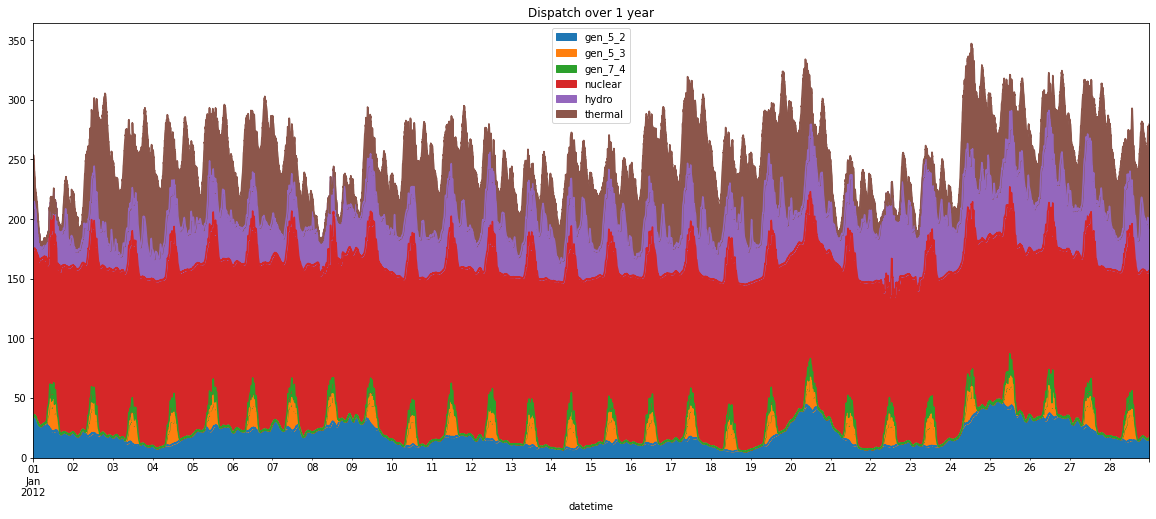

In [29]:
if not DispatchByCarrierOnly:
    nuclear_names = dispatch.generators[dispatch.generators.carrier == 'nuclear'].index
    hydro_names = dispatch.generators[dispatch.generators.carrier == 'hydro'].index
    thermal_names = dispatch.generators[dispatch.generators.carrier == 'thermal'].index

    dispatch_by_fleet=pd.concat([ dispatch.wind_p, dispatch.solar_p], axis=1)
    dispatch_by_fleet['nuclear'] = full_opf_dispatch[nuclear_names].sum(axis=1).to_frame('Nuclear')
    dispatch_by_fleet['hydro'] = full_opf_dispatch[hydro_names].sum(axis=1)
    dispatch_by_fleet['thermal'] = full_opf_dispatch[thermal_names].sum(axis=1)
    #dispatch_by_fleet=pd.concat([dispatch_by_fleet, dispatch.wind_p, dispatch.solar_p], axis=1)

    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0

    # grid2op env starts in 2007 but read loads are in 2012...
    #dispatch_by_fleet = dispatch_by_fleet.loc[dispatch_by_fleet.index.year == 2007,:]

    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')

else:
    dispatch_by_fleet=full_opf_dispatch
    
    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0 #due to numeric approximation,some thermal values  could be negative
    dispatch_by_fleet.loc[dispatch_by_fleet['hydro'] < 0, 'hydro'] = 0
    #full_opf_dispatch[full_opf_dispatch['thermal']<0]['thermal'].hist()
    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')


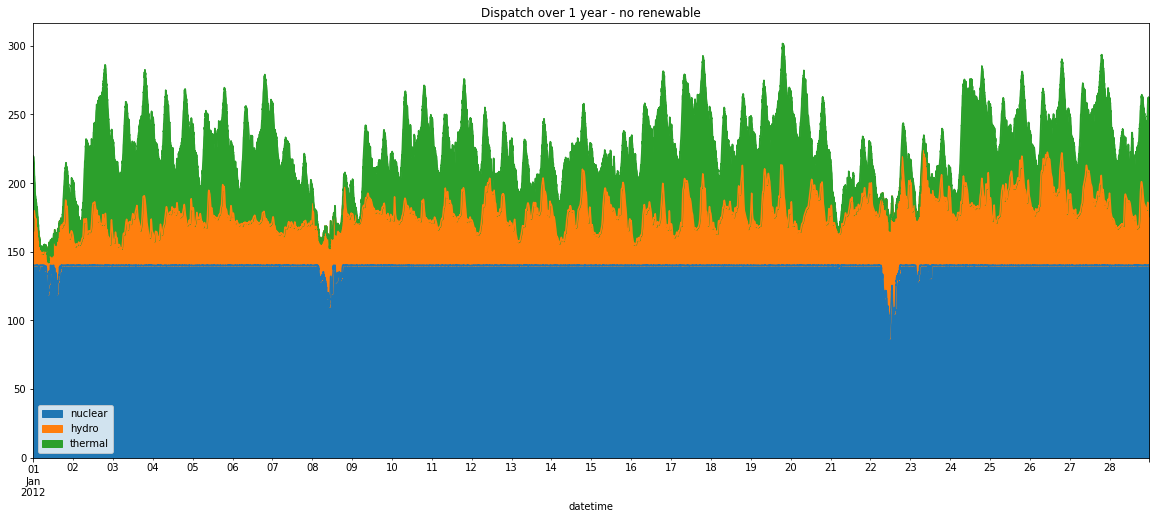

In [30]:
dispatch_by_fleet[['nuclear','hydro','thermal']].plot(figsize=(20, 8), title='Dispatch over 1 year - no renewable', kind='area')

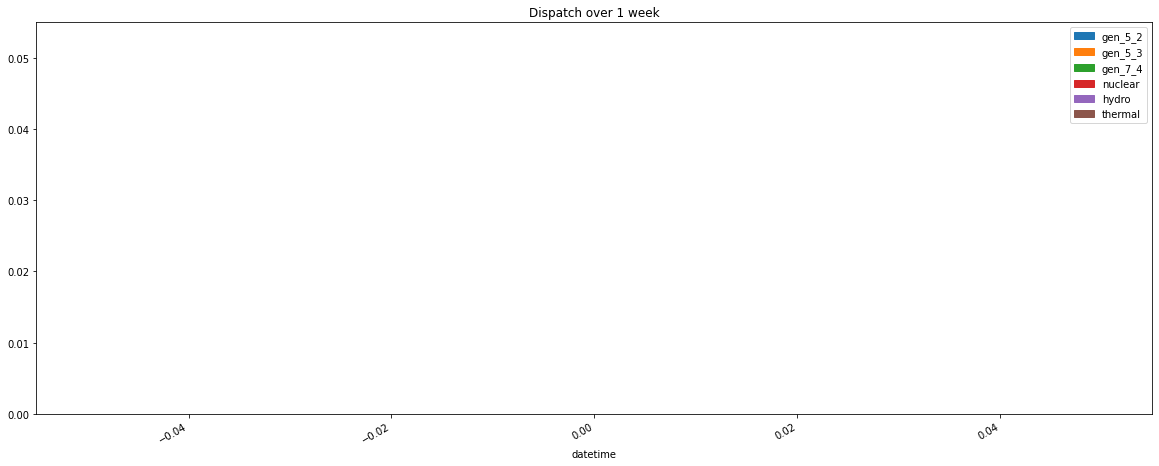

In [31]:
WeekNumber=24
dispatch_by_fleet.iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week', kind='area')

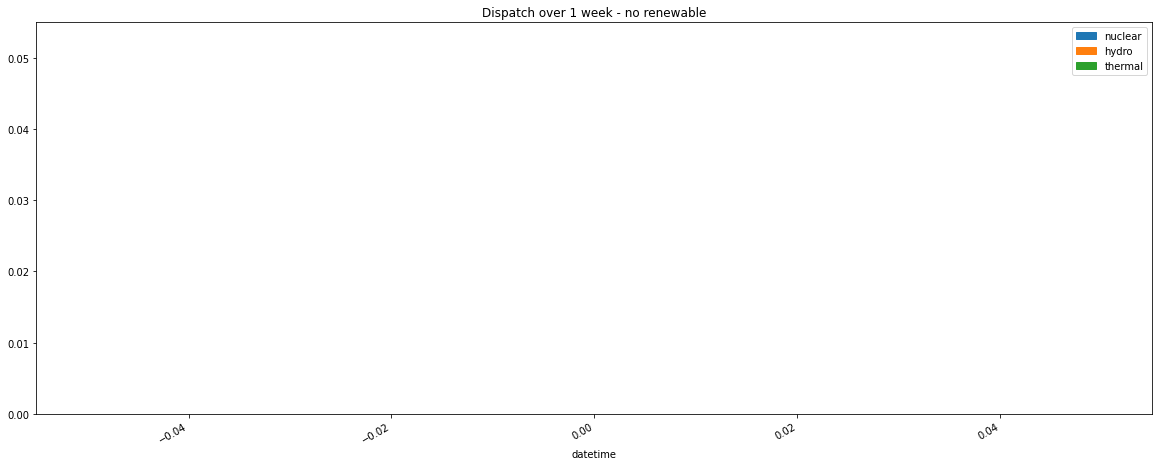

In [32]:
dispatch_by_fleet[['nuclear','hydro','thermal']].iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week - no renewable', kind='area')

Check Hydro 

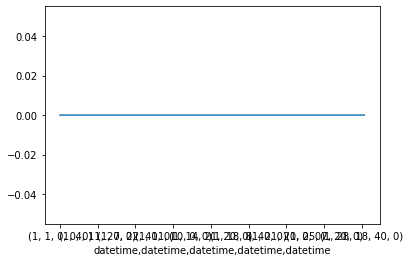

In [33]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
if not(dispatch_by_fleet[['hydro']].sum().values==0):
    minHydroPattern=dispatch._min_hydro_pu
    nCols=minHydroPattern.shape[1]
    minHydroPattern.iloc[:,0].plot()

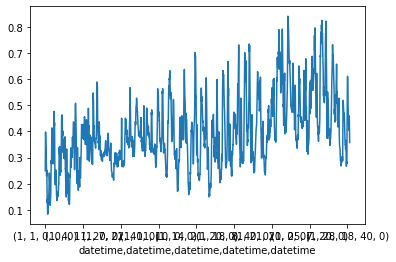

In [34]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
if not(dispatch_by_fleet[['hydro']].sum().values==0):
    maxHydroPattern=dispatch._max_hydro_pu
    nCols=maxHydroPattern.shape[1]
    maxHydroPattern.iloc[:,0].plot()

In [35]:
# Validate whether they have same order
np.all(full_opf_dispatch.columns == env118_withoutchron.name_gen)

True

Check Energy Mix of Dispatch and capacity factors

In [36]:
CurrentAverageLoad=load.sum(axis=1).mean()
dispatch_by_fleet[['nuclear','hydro','thermal']].mean()/CurrentAverageLoad

nuclear    0.542972
hydro      0.155581
thermal    0.180349
dtype: float64

In [37]:
dispatch_by_fleet[['nuclear','hydro','thermal']].mean()/dispatch_by_fleet[['nuclear','hydro','thermal']].max()

nuclear    0.992053
hydro      0.475356
thermal    0.408889
dtype: float64

### Compute some KPIs for dispatch
As I never had a dispatch output file, I didn't have a precise output format for the dispatch to be taken into account by the KPI module.So I chose to take the format of the only example i had: chronics exported by a previous script of Camilo with month by month dispatch chronics. 
- Download these files to have a format example on Nextcloud: https://nextcloud.artelys.com/nextcloud/s/tFirA3TRXrHeFwC
- Careful, this example is for year 2007
- We should agree on an output format from dispatch. Maybe you could put it on Nextcloud as an example for me

#### You have to set "eco2mix" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
**Images were not designed to be plot on a notebook but to be saved as png or zoomable in IMAGES_FOLDER**. In particular, yearly productions and energy mix are better to watch in their written files

In [38]:
%%capture

wind_solar_only = False
if not os.path.exists(KPI_INPUT_FOLDER):
    os.mkdir(KPI_INPUT_FOLDER)
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, IMAGES_FOLDER, year, CASE, n_scenarios, wind_solar_only, params)

KeyError: 'zone'

# III Create an environment with the chronics this time

This is to test the environment can be used by grid2op. This is what the "case118_l2rpn" will look like for the competitions.

**NB** The "Balthazar code" is fully compatible with the "GridStateFromFileWithForecasts". So it is useful to use this class to load back the data. If the data generation process does not provide the same utilities, it is not a problem to write another class, like "GridStateFromFileWithForecasts" that can read its format.

### Correct the bug in element 7_4_173

In [67]:
# NO YOU SHOULD NOT DO THAT BUT BE ABLE TO RUN ALL SCENARIOS IN THE RUNNER.

# Chose generated scenario
# scenario = 'Scenario_15'
# scenario_path = os.path.join(OUTPUT_FOLDER, str(year), scenario)


** I can't run from the following cell: can't make the dispatch run on my machine and don't data in the right format**

In [82]:
from grid2op.Chronics import Multifolder, GridStateFromFileWithForecasts
from grid2op.Parameters import Parameters
try:
    from pyklu2grid.PyKLUBackend import PyKLUBackend
    backend = PyKLUBackend()
except:
    from grid2op.Backend import PandaPowerBackend
    backend = PandaPowerBackend()
    print("You might need to install the pklu backend (provisory name) to gain massive speed up")
# don't disconnect powerline on overflow, the thermal limit are not set for now, it would not make sens
param = Parameters()
param.init_from_dict({"NO_OVERFLOW_DISCONNECTION": True})

env = grid2op.make("blank",  # to generate a blank environment
                   grid_path=grid_path, # assign it the 118 grid
                   chronics_class=Multifolder, # tell it to change nothing (not the most usable environment...)
                   data_feeding_kwargs= {"path": OUTPUT_FOLDER, "gridvalueClass": GridStateFromFileWithForecasts},
                   param=param,
                   backend=backend
                  )
# If you remove the "GridStateFromFileWithForecasts", from above, chronics will NOT be loaded properly.
# GridStateFromFileWithForecasts is the format used for the competition, so it is mandatory that this works!
# WITHOUT ANY MODIFICATIONS

# Beside the environment should be able to load all data generated, and not one episode.
# so please look in grid2op for compatible formats. This is not a valid format.

ChronicsError: Grid2OpException ChronicsError "Element named datetime is found in the data (column 1) but it is not found on the powergrid for data of type "loads".
Data in files  are: ['datetime', 'load_10_7', 'load_11_8', 'load_12_9', 'load_13_10', 'load_1_0', 'load_2_1', 'load_3_2', 'load_4_3', 'load_5_4', 'load_8_5', 'load_9_6']
Converter data are: ['load_10_7', 'load_11_8', 'load_12_9', 'load_13_10', 'load_1_0', 'load_2_1', 'load_3_2', 'load_4_3', 'load_5_4', 'load_8_5', 'load_9_6']"

In [57]:
#set env thermal limit to 1 by default
th_lim = np.ones(env.n_line, dtype=np.float)
env.set_thermal_limit(th_lim)

And now we can test that we can use a Runner, store the results, and plot the flows on the powerline for example

# IV Validate the generation process

For that we use a runner, that will compute the powerflows with a "do nothing" agent, and we prevent it to disconnect any power line, even if they are on overflow.

In [69]:
from grid2op.Runner import Runner
import tempfile
from tqdm.notebook import tqdm
path_data_saved = os.path.join(scenario_path, '..', 'agent_results')
nb_episode = 1
#nb_steps = 400
runner = Runner(**env.get_params_for_runner())

# here you might need to change "nb_episode" if you generated more than one scenario
# this might really take some times... 4 mins per scenario per week [on one core]
res = runner.run(nb_episode=nb_episode, path_save=path_data_saved, pbar=tqdm)

In [60]:
!ls $path_data_saved

chronics		dict_env_modification_space.json
dict_action_space.json	dict_observation_space.json


Then we can study the results, for example by loading the chronics, extracting prod p, load p etc.

In [62]:
from grid2op.EpisodeData import EpisodeData
import numpy as np
from tqdm.notebook import tqdm

data_this_episode = EpisodeData.from_disk(path_data_saved, "chronics")

In [64]:
flows_a = np.array([obs.a_or for obs in data_this_episode.observations])
loads_p = np.array([obs.load_p for obs in data_this_episode.observations])
prods_p = np.array([obs.prod_p for obs in data_this_episode.observations])


display distribution of flows over scenarios

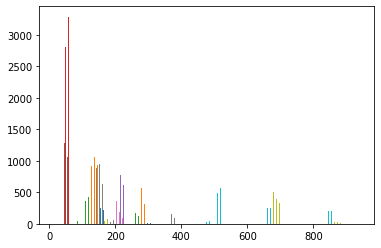

In [66]:
import matplotlib.pyplot as plt
_ = plt.hist(flows_a,bins=100)

Computes the KPI you want with that...

In [ ]:
# TODO

Go back to **II)** if results are not satisfying.

# V Export the final results

First, regenerate a lot more data, then save then

In [ ]:
# TODO generate more data with the same distribution as the one that has been validated

In [ ]:
# TODO export them to be usable in a friendly manner